## Setup

In [262]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from IPython import display
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["figure.dpi"] = 100

In [263]:
def plotMagnetization(dt, M_to_plot):
    time_vector = np.array(range(len(M_to_plot)))*dt
    plt.plot(time_vector, np.array(M_to_plot)[:,0])
    plt.plot(time_vector, np.array(M_to_plot)[:,1])
    plt.plot(time_vector, np.array(M_to_plot)[:,2])
    plt.ylabel("Magnetization")
    plt.xlabel("Time (s)")
    plt.legend(['Mx', 'My', 'Mz'])
    plt.ylim([np.array(M_to_plot).min() - 0.1, np.array(M_to_plot).max() + 0.1])
    
def plotComplexMagnetization(dt, M_to_plot):
    fig, axs = plt.subplots(2)
    axs[0].set_ylabel("Amplitude")
    axs[1].set_ylabel("Angle (degree)")
    axs[1].set_xlabel("Time (s)")
    axs[0].set_title('Complex transverse magnetization')
    Mxy = []
    for M_i in M_to_plot:
        # Mxy = Mx + i*My
        Mxy.append(complex(M_i[0], M_i[1]))
    Mxy= np.array(Mxy, dtype=np.complex_)
    time_vector = np.array(range(len(M)))*dt
    axs[0].plot(time_vector, np.abs(Mxy))

    axs[1].plot(time_vector, np.rad2deg(np.angle(Mxy)))
    
    return Mxy

def excitation(M_to_excite, flip_angle):
    dTheta = np.deg2rad(flip_angle)
    
    A = np.array([
        [1, 0, 0],
        [0, np.cos(dTheta), np.sin(dTheta)],
        [0,-np.sin(dTheta),  np.cos(dTheta)],
    ])
    
    M_to_excite[-1] = A @ M_to_excite[-1]

def relaxation(M_to_relax, dt, duration, phi):
    A = np.array([
        [np.exp(-dt/T2), 0, 0],
        [0, np.exp(-dt/T2), 0],
        [0, 0, np.exp(-dt/T1)],
    ])

    B = np.array([
        0,
        0,
        1*(1 - np.exp(-dt/T1))
    ])
    
    Z = [[np.cos(phi), np.sin(phi), 0],
     [-np.sin(phi), np.cos(phi), 0],
     [0, 0, 1]]
    
    for _ in range(int(duration/dt)):
        M_to_relax[-1] = Z @ M_to_relax[-1]
        M_to_relax.append(A @ M_to_relax[-1] + B)
        
def spin_echo(M_param, phi):
    # Relaxation
    relaxation(M_param, dt, duration=TE/2,  phi=phi)

    # Refocusing
    excitation(M_param, flip_angle = 180)

    # Relaxation
    relaxation(M_param, dt, duration=TR-TE/2,  phi=phi)

def func(x, a, b, c):
    return a * np.exp(b * x) 

def estimate_exponential(Mxy):
    time_vector = np.array(range(len(Mxy)))*dt
    y = np.array(Mxy)

    peaks = find_peaks(y, distance=10)
    peaks = peaks[0]
    x = [time_vector[i] for i in peaks]
    x = np.array(x)
    y = [y[i] for i in peaks] 
    popt, pcov = curve_fit(func, x, y,  p0=(1, 1e-6, 1))
    a, b, c = popt
    plt.plot(x, func(x, a, b, c))
    T2_calc=-1000/b
    return T2_calc

## Declaring constants

In [264]:
# Relevant information
M0 = np.array([0, 0, 1])
dt = 0.5/1000   # ms
T1 = 400/1000.0  # ms
T2 = 40/1000.0    # ms
TE = 10/1000.0     # ms
TR = 100/1000.0   # ms

## Question 1

Simulate the evolution of the magnetization during one TR and plot each
magnetization component as a function of time.

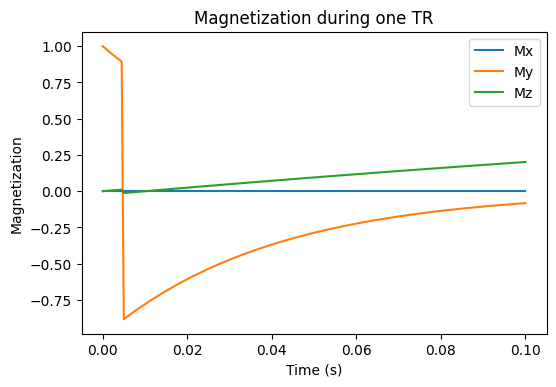

In [265]:
M = [M0]
# Excitation
excitation(M, flip_angle = 90)
spin_echo(M, phi=0)
plotMagnetization(dt, M)
plt.title("Magnetization during one TR")
M = np.array(M)

## Question 2

Compute the complex transverse magnetization, and plot its amplitude and phase as
a function of time.

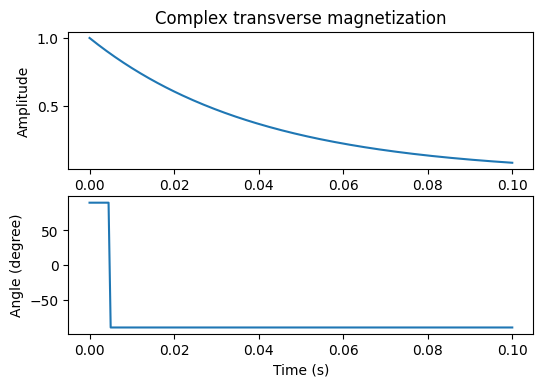

In [266]:
_ = plotComplexMagnetization(dt, M)

Now consider an ensemble of off-resonance spins with Δω between -60 and +60 Hz, in steps of
1 Hz

## Question 3. 
Repeat 1. and 2.; for the plots, consider the average magnetization of all spins.

Text(0.5, 1.0, 'One TR')

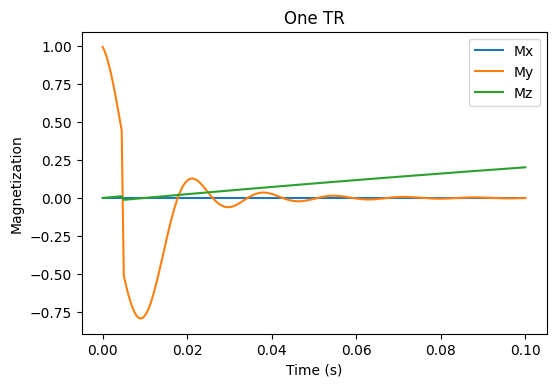

In [267]:
delta_omega_range = np.arange(-60, 61, 1)  
M_delta = []
for delta_omega in delta_omega_range:
    M = [M0]
    # Excitation
    excitation(M, flip_angle = 90)
    spin_echo(M, phi=delta_omega*dt*2*np.pi)
    M_delta.append(M)
    
M_delta = np.array(M_delta)
_, time, __  = np.shape(M_delta)

M_avg = []
for t in range(time):
    Mx = np.mean(M_delta[:, t, 0])
    My = np.mean(M_delta[:, t, 1])
    Mz = np.mean(M_delta[:, t, 2])
    M_avg.append([Mx, My, Mz])

plotMagnetization(dt, M_avg)
plt.title("One TR")

T2* calc:  7.030361013781874


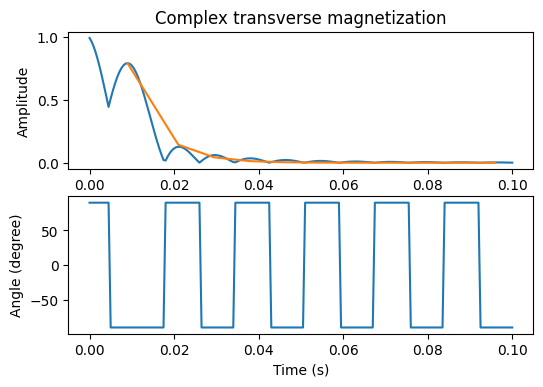

In [268]:
# _ = plotComplexMagnetization(dt, M_avg)
Mxy = np.abs(plotComplexMagnetization(dt, M_avg))
plt.subplot(211)
T2_calc = estimate_exponential(Mxy)
print("T2* calc: ", T2_calc)

## Question 4
Repeat 3. for a multiple spin-echo experiment with 8 echoes and determine the T2 of the sample using the data measured in this experiment.

Text(0.5, 1.0, '8 echos')

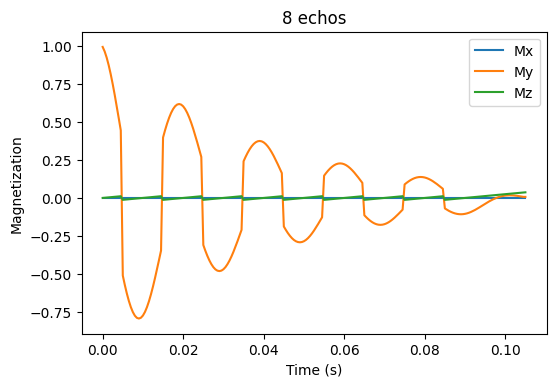

In [269]:
delta_omega_range = np.arange(-60, 61, 1)  
M_delta = []
for delta_omega in delta_omega_range:
    M = [M0]
    # Excitation
    phi = delta_omega*dt*2*np.pi
    excitation(M, flip_angle = 90)
    relaxation(M, dt, duration=TE/2,  phi=phi)
    # Refocusing
    excitation(M, flip_angle = 180)
    for i in range(8):
        relaxation(M, dt, duration=TE,  phi=phi)
        excitation(M, flip_angle = 180)
    relaxation(M, dt, duration=TR-8*TE,  phi=phi)
    M_delta.append(M)
    
M_delta = np.array(M_delta)
_, time, __  = np.shape(M_delta)

M_avg = []
for t in range(time):
    Mx = np.mean(M_delta[:, t, 0])
    My = np.mean(M_delta[:, t, 1])
    Mz = np.mean(M_delta[:, t, 2])
    M_avg.append([Mx, My, Mz])

plotMagnetization(dt, M_avg)

plt.title("8 echos")

T2 calc:  38.860679185842045


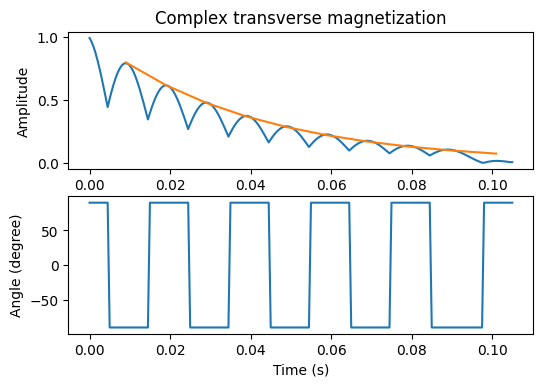

In [270]:
Mxy = np.abs(plotComplexMagnetization(dt, M_avg))
plt.subplot(211)
T2_calc = estimate_exponential(Mxy)
print("T2 calc: ", T2_calc)